# Gradcam for text classification

This is implementation of [Grad Cam](https://arxiv.org/abs/1610.02391) for text classification

In [27]:
import pandas as pd
import gc
import torch
from fastai.text import *
from gensim.models import Word2Vec
from sklearn.metrics import classification_report

In [28]:
"""Constants"""
PADDING = "<end>"
SEQUENCE_LENGTH = 59
BATCH_SIZE = 50

In [29]:
model_path = "/home/saurabh/Documents/fastai/gradcam_text/data/"
path = Path("/home/saurabh/Documents/fastai/gradcam_text/data/stanford")

## Use word2vec embeddings

- Pytorch embeddings are loaded into embedding layer

In [30]:
language_model = Word2Vec.load(model_path+"/w2v.model")

"""embedding layer"""
weights = torch.FloatTensor(language_model.wv.vectors)
embedding = torch.nn.Embedding.from_pretrained(weights)

""""""
vocab = language_model.wv.vocab
word_vec = language_model.wv

language_model = None

"""Clear the memory"""
gc.collect()

/home/saurabh/.local/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


0

## Load data

In [31]:
def loadData(path, maxwordCount = SEQUENCE_LENGTH):
    df = pd.DataFrame(columns=['sentement', 'text', 'tokens'])
    with open(path) as file:
        line = file.readline()
        index = 0
        while line:
            sentement = int(line[0])
            text = line[2:]
            tokens = text.split()
            
            if len(tokens) > maxwordCount:
                print("Snipping additional tokens")
                tokens = tokens[0:maxwordCount]
                
    
            df.loc[index] = [sentement, text, tokens]
            
            """Append """
            line = file.readline()
            index+=1
    return df

In [32]:
df_train = loadData(path/"stsa.binary.train")
df_test = loadData(path/"stsa.binary.test")

In [33]:
"""Function to tokenize the input text"""
def map_tokens(data, vocab, padding = PADDING, sequence_length = SEQUENCE_LENGTH):
    indexed_tokens = []
    
    for tokens in data:
        indexed_token = []
        for token in tokens:
            if token in vocab:
                indexed_token.append(vocab[token].index)
        
        if len(indexed_token) < sequence_length:
                indexed_token.extend([vocab[padding].index] * (sequence_length - len(indexed_token)))
        indexed_tokens.append(indexed_token)
    return indexed_tokens


x_train = df_train.tokens
x_train = map_tokens(x_train, vocab)
y_train = df_train.sentement
x_train = torch.LongTensor(x_train)
y_train = torch.tensor(y_train)
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)


x_test = df_test.tokens    
x_test = map_tokens(x_test, vocab)
y_test = df_test.sentement
x_test = torch.LongTensor(x_test)
y_test = torch.tensor(y_test)
test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

## Network Structure

In [34]:
class ConvTextNet(nn.Module):
    
    def __init__(self, embedding, embedding_size, sequence_length, classes, keep_probability):
        super().__init__()
        self.embedding = embedding
        self.embedding_size = embedding_size
        self.sequence_length = sequence_length
        self.classes = classes
        self.keep_probability = keep_probability
        
        self._initialize_layers()
    
    
    def _initialize_layers(self):
        
        self.conv_three = torch.nn.Sequential(
                                                torch.nn.Conv2d(in_channels=1, out_channels=512, 
                                                                kernel_size=(3, self.embedding_size),
                                                                stride=(1, self.embedding_size)),
                                                torch.nn.ReLU()
        )


        self.conv_four = torch.nn.Sequential(
                                                torch.nn.Conv2d(in_channels=1, out_channels=512, 
                                                                kernel_size=(4, self.embedding_size), 
                                                                stride=(1, self.embedding_size)),
                                                torch.nn.ReLU()
        )


        self.conv_five = torch.nn.Sequential(
                                                torch.nn.Conv2d(in_channels=1, out_channels=512, 
                                                                kernel_size=(5, self.embedding_size), 
                                                                stride=(1, self.embedding_size)),
                                                torch.nn.ReLU()
        )

    
        self.max_pool_three = torch.nn.Sequential(
                                                 torch.nn.MaxPool2d(kernel_size=(self.sequence_length - 3 + 1, 1))
        )
    
        self.max_pool_four = torch.nn.Sequential(
                                                 torch.nn.MaxPool2d(kernel_size=(self.sequence_length - 4 + 1, 1))
        )

        self.max_pool_five = torch.nn.Sequential(
                                                 torch.nn.MaxPool2d(kernel_size=(self.sequence_length - 5 + 1, 1))
        )
        
        self.fc = torch.nn.Sequential(
                                      torch.nn.Linear(3 * 512, 100),
                                      torch.nn.ReLU(),
                                      torch.nn.Dropout(self.keep_probability),
                                      torch.nn.Linear(100, 50),
                                      torch.nn.ReLU(),
                                      torch.nn.Dropout(self.keep_probability),
                                      torch.nn.Linear(50, self.classes),
        )
        

    def forward(self, x):
        
        out = embedding(x).view(-1, 1, self.sequence_length, self.embedding_size)
        
        out_cnn_three = self.conv_three(out)
        out_cnn_four = self.conv_four(out)
        out_cnn_five = self.conv_five(out)
        
        out_max_three = self.max_pool_three(out_cnn_three)
        out_max_four = self.max_pool_four(out_cnn_four)
        out_max_five = self.max_pool_five(out_cnn_five)
        
        total_filters = 512 * 3
        
        self.concat_layer = torch.cat([out_max_three, out_max_four, out_max_five], 3)
        self.flattened_layer = torch.reshape(self.concat_layer, [-1, total_filters])
        
        out = self.fc(self.flattened_layer)
        return out

    


def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            
            losses_test, nums_test = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
            
            losses_train, nums_train = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in train_dl]
            )            
            
        val_loss_test = np.sum(np.multiply(losses_test, nums_test)) / np.sum(nums_test)
        val_loss_train = np.sum(np.multiply(losses_train, nums_train)) / np.sum(nums_train)
        
        print(epoch, "Train", val_loss_train, "Validation", val_loss_train)

        if epoch%10 == 0:
            f_name = "model_"+str(epoch)+".model"
            torch.save(model, path/f_name)

## Load Saved model

In [35]:
model = torch.load(model_path+"/model_10.model")

/home/saurabh/.local/lib/python3.6/site-packages/torch/serialization.py:420: UserWarning: Couldn't retrieve source code for container of type ConvTextNet. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


## Check performance of model - F1 score

In [36]:
model.eval()
_predictions = []
_gt = []
for xb, yb in test_dl:
    output = model(xb)
    _, predicted = torch.max(output, 1)
    
    _predictions.extend(predicted.data.numpy())
    _gt.extend(yb)
print(classification_report(_gt, _predictions, target_names = ['bad', 'good']))

              precision    recall  f1-score   support

         bad       0.74      0.86      0.80       912
        good       0.83      0.70      0.76       909

   micro avg       0.78      0.78      0.78      1821
   macro avg       0.79      0.78      0.78      1821
weighted avg       0.79      0.78      0.78      1821



## GradCam

In [37]:
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

In [38]:
def get_grad_cam(model, x, target_class):
    
    hook_F_three = Hook(model.max_pool_three)
    hook_B_three = Hook(model.max_pool_three, backward=True)

    hook_F_four = Hook(model.max_pool_four)
    hook_B_four = Hook(model.max_pool_four, backward=True)

    hook_F_five = Hook(model.max_pool_five)
    hook_B_five = Hook(model.max_pool_five, backward=True)
    
    """Forward pass"""
    out = model(x.reshape((1, -1)))
    
    """Backward pass"""
    out.backward(torch.tensor(target_class, dtype=torch.float),retain_graph=True)
    
    """Calculate gradcam"""
    _alpha_c = hook_B_three.input[0].mean(2).flatten()
    output_three = (hook_F_three.input[0][0] * _alpha_c[...,None,None]).mean(0)
    
    _alpha_c = hook_B_four.input[0].mean(2).flatten()
    output_four = (hook_F_four.input[0][0] * _alpha_c[...,None,None]).mean(0)
    
    _alpha_c = hook_B_five.input[0].mean(2).flatten()
    output_five = (hook_F_five.input[0][0] * _alpha_c[...,None,None]).mean(0)
    
    hook_F_three.close()
    hook_B_three.close()
    
    hook_F_four.close()
    hook_B_four.close()
    
    hook_F_five.close()
    hook_B_five.close()
    
    return output_three, output_four, output_five

In [49]:
def plot(grad_cam_three, grad_cam_four, grad_cam_five, words, use_relu = True):
    
    if use_relu:
        grad_cam_three = torch.nn.functional.relu(grad_cam_three)
        grad_cam_four = torch.nn.functional.relu(grad_cam_four)
        grad_cam_five = torch.nn.functional.relu(grad_cam_five)
    
    
    plt.figure(figsize=(14,10))
    plt.imshow(grad_cam_three.reshape(1, -1), alpha=0.6, extent=(0,58,5,0),
              interpolation='bilinear');
    plt.title("CNN 3gram")
    plt.xticks(range(0, 59), _x_words, fontsize=12, rotation='vertical')
    plt.show()
    
    plt.figure(figsize=(14,10))
    plt.imshow(grad_cam_four.reshape(1, -1), alpha=0.6, extent=(0,58,5,0),
              interpolation='bilinear');
    plt.title("CNN 4gram")
    plt.xticks(range(0, 59), _x_words, fontsize=12, rotation='vertical')
    plt.show()
    
    plt.figure(figsize=(14,10))
    plt.imshow(grad_cam_five.reshape(1, -1), alpha=0.6, extent=(0,58,5,0),
              interpolation='bilinear');
    plt.title("CNN 5gram")
    plt.xticks(range(0, 59), _x_words, fontsize=12, rotation='vertical')
    plt.show()
    
    
    plt.figure(figsize=(14,10))
    plt.title("Combined")
    plt.imshow(grad_cam_three.reshape(1, -1), alpha=0.6, extent=(0,58,5,0),
                  interpolation='bilinear');

    plt.imshow(grad_cam_four.reshape(1, -1), alpha=0.6, extent=(0,58,5,0),
                  interpolation='bilinear', cmap='magma');


    plt.imshow(grad_cam_five.reshape(1, -1), alpha=0.6, extent=(0,58,5,0),
                  interpolation='bilinear', cmap='cividis');

    plt.xticks(range(0, 59), _x_words, fontsize=12, rotation='vertical')
    plt.show()

## Grad cam samples

In [58]:
index = 2
_x, _y = test_ds[index]
_x_words = [word_vec.index2word[_index] for _index in _x]

print(df_test.text[index])
print("Ground truth "+str(_y))

gangs of new york is an unapologetic mess , whose only saving grace is that it ends by blowing just about everything up .

Ground truth tensor(0)


### Negative class

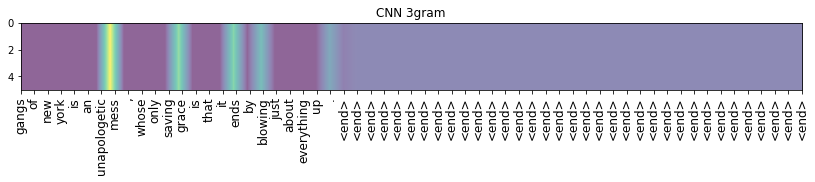

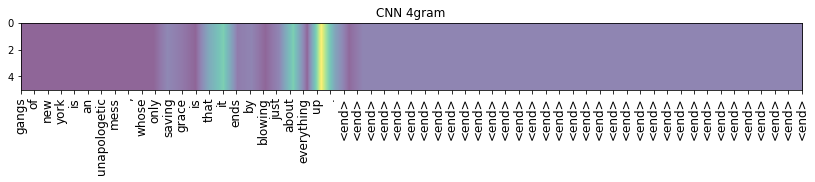

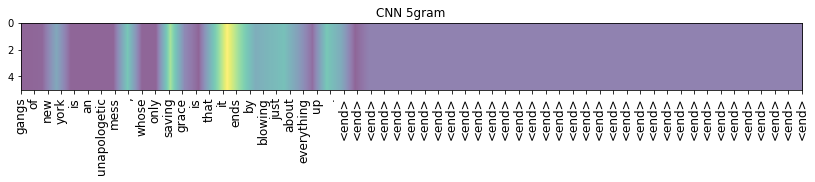

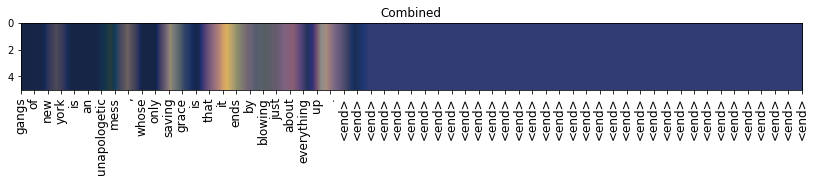

In [54]:
output_three, output_four, output_five = get_grad_cam(model, _x, [[1, 0]])
plot(output_three, output_four, output_five, _x_words)

### Positive class

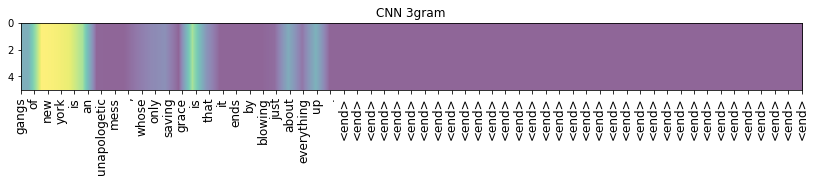

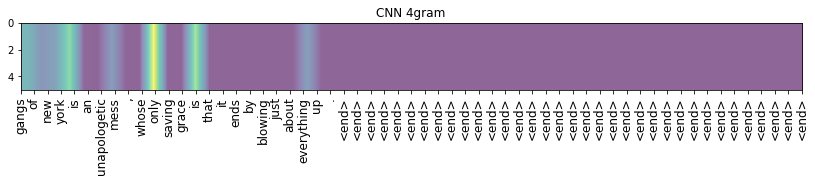

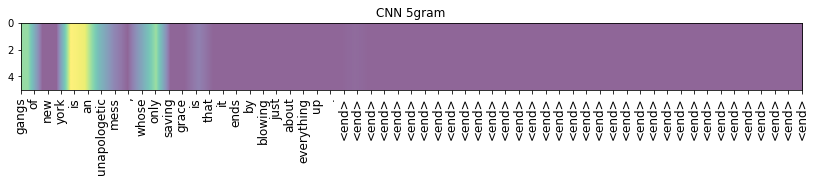

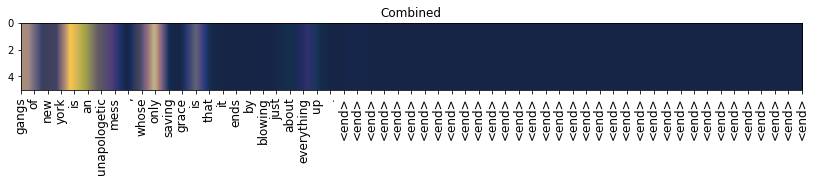

In [55]:
output_three, output_four, output_five = get_grad_cam(model, _x, [[0, 1]])
plot(output_three, output_four, output_five, _x_words)

In [61]:
index = 3
_x, _y = test_ds[index]
_x_words = [word_vec.index2word[_index] for _index in _x]

print(df_test.text[index])
print("Ground truth "+str(_y))

we never really feel involved with the story , as all of its ideas remain just that : abstract ideas .

Ground truth tensor(0)


### Negative class

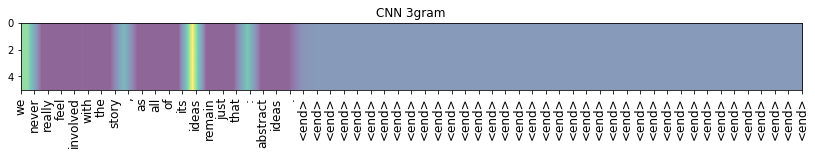

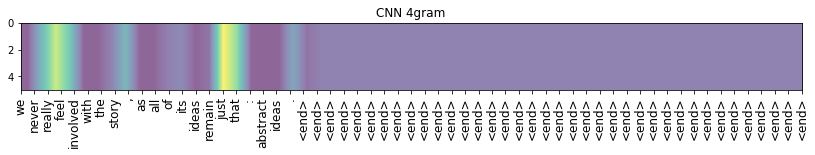

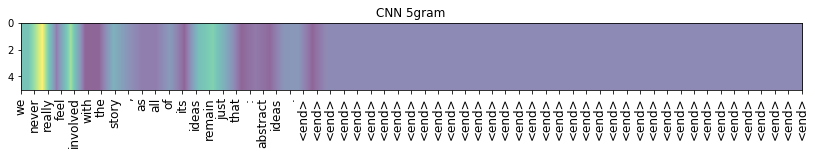

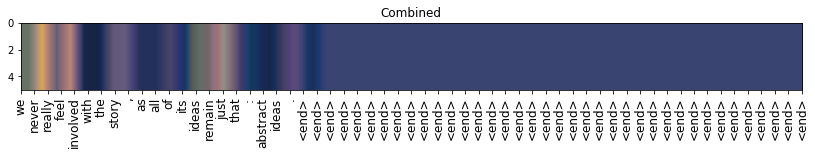

In [62]:
output_three, output_four, output_five = get_grad_cam(model, _x, [[1, 0]])
plot(output_three, output_four, output_five, _x_words)

### Positive class

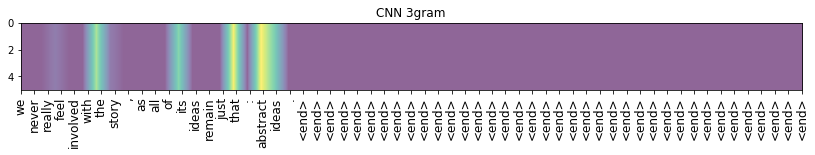

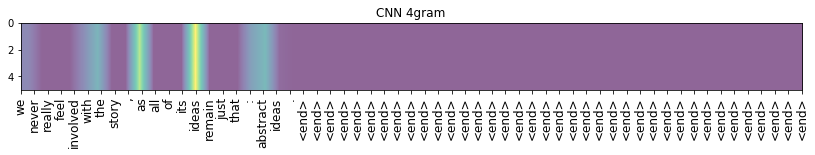

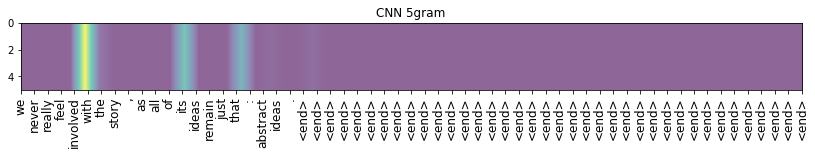

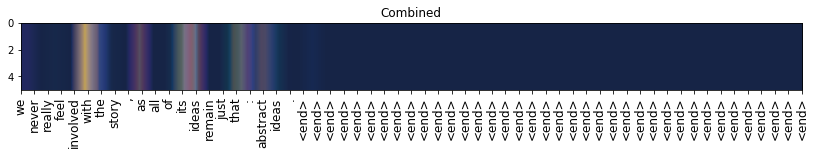

In [63]:
output_three, output_four, output_five = get_grad_cam(model, _x, [[0, 1]])
plot(output_three, output_four, output_five, _x_words)

In [64]:
index = 4
_x, _y = test_ds[index]
_x_words = [word_vec.index2word[_index] for _index in _x]

print(df_test.text[index])
print("Ground truth "+str(_y))

this is one of polanski 's best films .

Ground truth tensor(1)


### Negative class

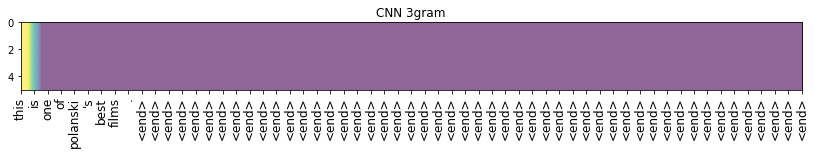

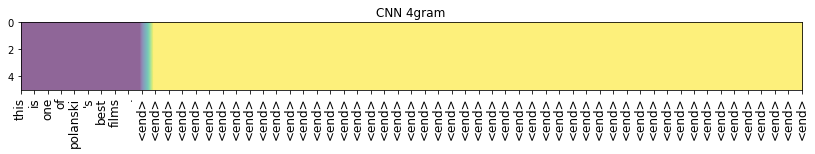

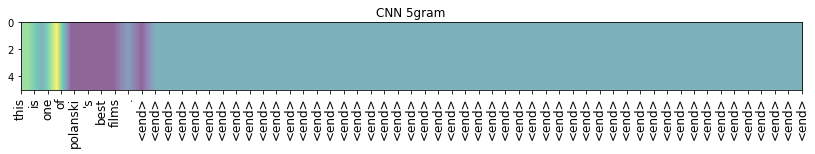

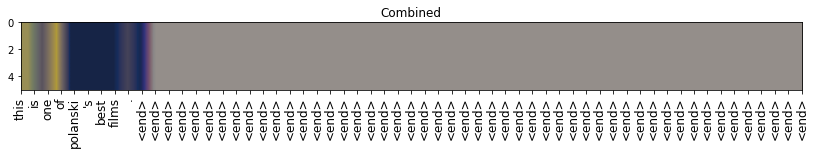

In [66]:
output_three, output_four, output_five = get_grad_cam(model, _x, [[1, 0]])
plot(output_three, output_four, output_five, _x_words)

### Positive class

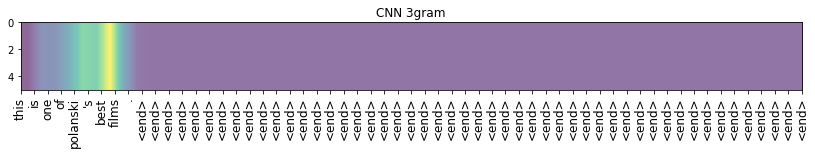

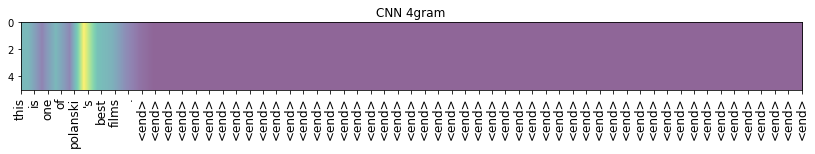

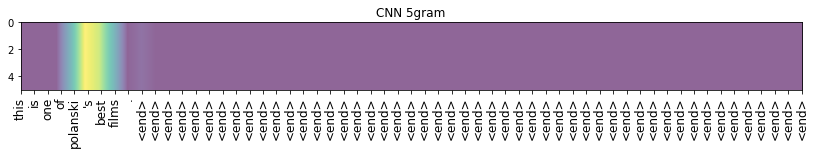

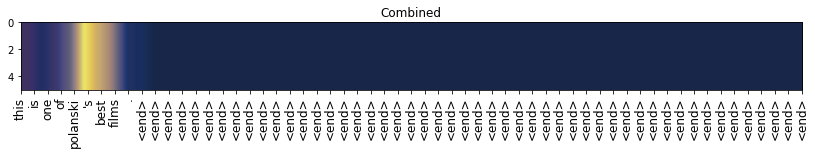

In [65]:
output_three, output_four, output_five = get_grad_cam(model, _x, [[0, 1]])
plot(output_three, output_four, output_five, _x_words)

In [67]:
index = 5
_x, _y = test_ds[index]
_x_words = [word_vec.index2word[_index] for _index in _x]

print(df_test.text[index])
print("Ground truth "+str(_y))

take care of my cat offers a refreshingly different slice of asian cinema .

Ground truth tensor(1)


### Negative class

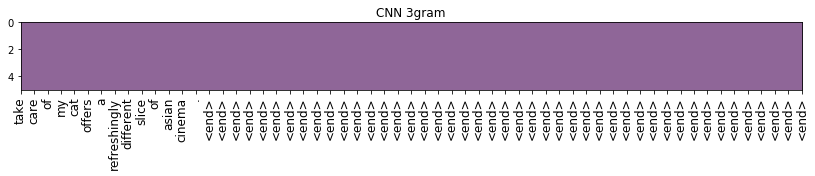

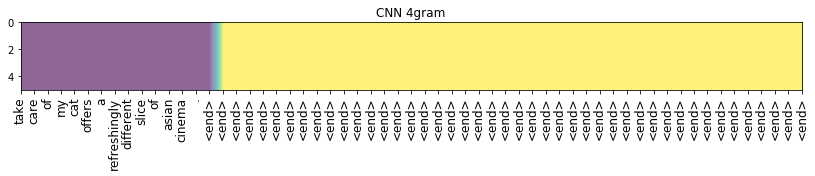

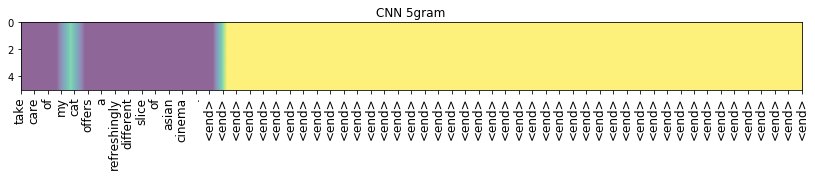

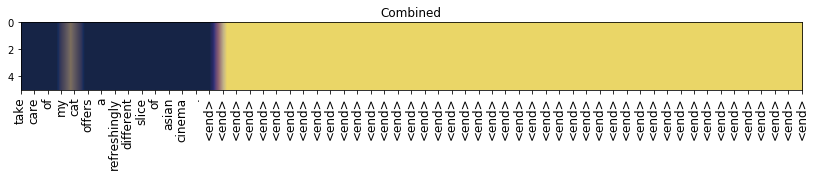

In [68]:
output_three, output_four, output_five = get_grad_cam(model, _x, [[1, 0]])
plot(output_three, output_four, output_five, _x_words)

### Positive class

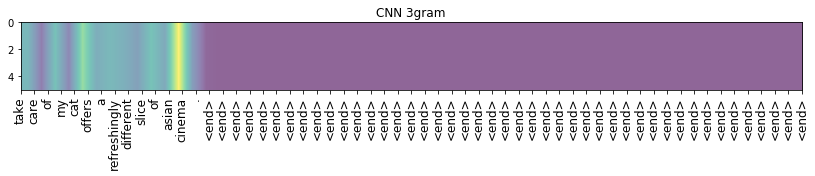

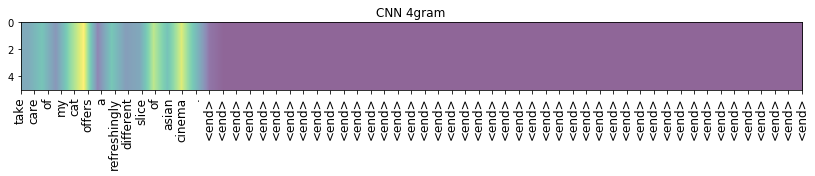

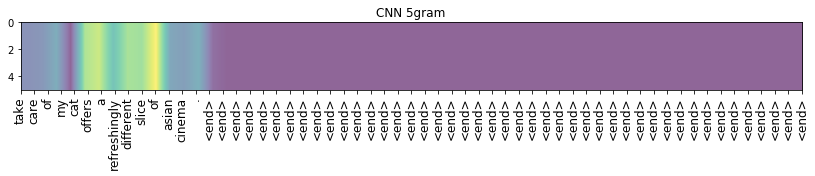

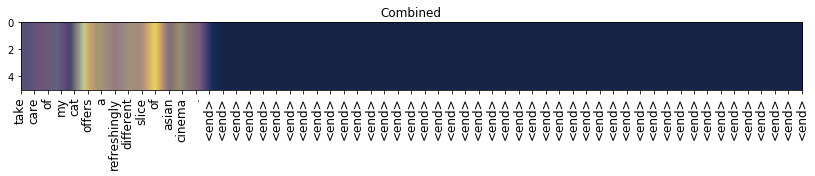

In [69]:
output_three, output_four, output_five = get_grad_cam(model, _x, [[0, 1]])
plot(output_three, output_four, output_five, _x_words)